# ASC Pan01 validation

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe
from pathlib import Path
import xgcm

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43037,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:38269,Total threads: 1
Dashboard: /proxy/32995/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:41471,


2025-10-04 19:14:43,667 - distributed.nanny - WARNING - Restarting worker
2025-10-04 19:14:43,671 - distributed.nanny - WARNING - Restarting worker
2025-10-04 19:14:43,697 - distributed.nanny - WARNING - Restarting worker
2025-10-04 19:14:43,703 - distributed.nanny - WARNING - Restarting worker
2025-10-04 19:14:43,708 - distributed.nanny - WARNING - Restarting worker
2025-10-04 19:14:43,712 - distributed.nanny - WARNING - Restarting worker
2025-10-04 19:14:43,717 - distributed.nanny - WARNING - Restarting worker
2025-10-04 19:14:43,721 - distributed.nanny - WARNING - Restarting worker
2025-10-04 19:14:43,742 - distributed.nanny - WARNING - Restarting worker
2025-10-04 19:14:43,745 - distributed.nanny - WARNING - Restarting worker
2025-10-04 19:14:43,750 - distributed.nanny - WARNING - Restarting worker
2025-10-04 19:14:43,755 - distributed.nanny - WARNING - Restarting worker
2025-10-04 19:14:43,788 - distributed.nanny - WARNING - Restarting worker
2025-10-04 19:14:43,794 - distributed.

In [3]:
# Importing data

pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month_z.nc'))

In [4]:
#Time variant variables
def preprocess(ds):
    ds = ds[['uo', 'vo','volcello']]
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')

In [5]:
#Time slicing
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))

uC = cont['uo'].sel(yh = slice(-80, -59), z_l = slice(None, 500)).sel(time=slice('2001-01-01','2010-12-31')).mean('time')
vC = cont['vo'].sel(yq = slice(-80, -59), z_l = slice(None, 500)).sel(time=slice('2001-01-01','2010-12-31')).mean('time')

In [6]:
cont_n = xr.merge([uC,vC])
cont_n= cont_n.isel(xq = slice(1, None), yq = slice(1, None))

In [7]:
path_to_ocean_static_C = Path('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output021/20000701.ocean_static.nc')
ocean_static_C = xr.open_dataset(path_to_ocean_static_C)

ocean_static_C = ocean_static_C.sel(xq = cont_n['xq'], xh = cont_n['xh'], yq = cont_n['yq'], yh = cont_n['yh'])

In [8]:
grid_C = xgcm.Grid(ocean_static_C, coords = {'X': {'center': 'xh', 'right': 'xq'},
                                             'Y': {'center': 'yh', 'right': 'yq'}},
                                               periodic = ['X'])

In [9]:
dh_dx_C = grid_C.interp(grid_C.diff(ocean_static_C['deptho'], 'X') / ocean_static_C['dxCu'], 'Y')
dh_dy_C = grid_C.interp(grid_C.diff(ocean_static_C['deptho'], 'Y') / ocean_static_C['dyCv'], 'X')

In [10]:
uC_int = grid_C.interp(cont_n['uo'], 'Y')
vC_int = grid_C.interp(cont_n['vo'], 'X')

In [11]:
uC_int

<xarray.DataArray 'uo' (z_l: 39, yq: 483, xq: 3600)> Size: 271MB
dask.array<transpose, shape=(39, 483, 3600), dtype=float32, chunksize=(22, 242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xq       (xq) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yq       (yq) float64 4kB -79.95 -79.9 -79.86 ... -59.11 -59.06 -59.01
Dimensions without coordinates: z_l

In [12]:
vC_int

<xarray.DataArray 'vo' (z_l: 39, yq: 483, xq: 3600)> Size: 271MB
dask.array<interp_center_to_right, shape=(39, 483, 3600), dtype=float32, chunksize=(22, 242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xq       (xq) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yq       (yq) float64 4kB -79.95 -79.9 -79.86 ... -59.11 -59.06 -59.01
Dimensions without coordinates: z_l

In [13]:
slope_C = np.sqrt(dh_dy_C**2 + dh_dx_C**2)

In [14]:
testC = uC_int*dh_dy_C - vC_int*dh_dx_C

In [15]:
alongslope_velocity_C = testC/slope_C

In [16]:
alongslope_velocity_C = alongslope_velocity_C.astype('float32')

In [17]:
alongslope_velocity_C

<xarray.DataArray (z_l: 39, yq: 483, xq: 3600)> Size: 271MB
dask.array<truediv, shape=(39, 483, 3600), dtype=float32, chunksize=(22, 241, 1029), chunktype=numpy.ndarray>
Coordinates:
  * xq       (xq) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yq       (yq) float64 4kB -79.95 -79.9 -79.86 ... -59.11 -59.06 -59.01
Dimensions without coordinates: z_l

In [18]:
alongslope_velocity_C = alongslope_velocity_C.load()

In [19]:
depth = xr.open_dataset(path_to_ocean_static_C)['deptho']
area = xr.open_dataset(path_to_ocean_static_C)['areacello']
var = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output021/20000701.ocean_month_z.nc')['so'].isel(time=0,z_l=0)

In [20]:
area_corr = area*(var*0 +1)

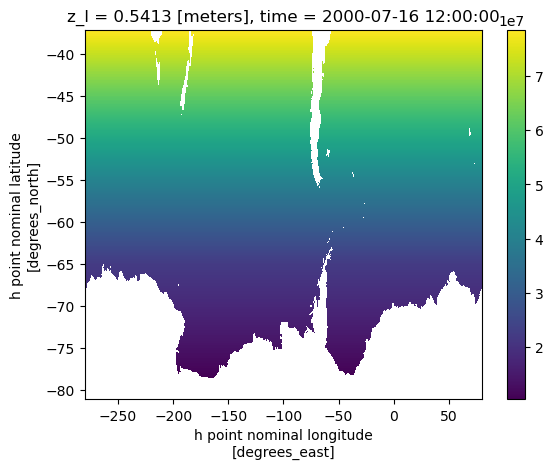

In [21]:
area_corr.plot()

In [23]:
volcello = cont['volcello'].mean(dim='time')

In [24]:
thickness = volcello / area_corr
thickness = thickness.sel(yh=slice(-80, -59)).sel(z_l=slice(None, 500))

In [25]:
alongslope_velocity_C

<xarray.DataArray (z_l: 39, yq: 483, xq: 3600)> Size: 271MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.08963161, -0.10478885, -0.09332459, ..., -0.01057942,
         -0.09660915, -0.09180114],
        [-0.10143252, -0.10527005, -0.10047577, ..., -0.01959458,
         -0.09324502, -0.08023146],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.02758802, -0.03778644, -0.03578624, ...,  0.00359062,
         -0.02953096, -0.02816314],
        [-0.03299152, -0.03772134, -0.03335896, ..., -0.00071931,
         -0.0279667 , -0.02295475],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.02630247, -0.03589289, -0.0339595 , ...,  0.00305819,
         -0.0280445 , -0.02681351],
        [-0.03140739, -0.03583732, -0.03179121, ..., -0.0011397 ,
         -0.02667005, -0.02197987],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * xq       (xq) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yq       (yq) float64 4kB -79.95 -79.9 -79.86 ... -59.11 -59.06 -59.01
Dimensions without coordinates: z_l

In [26]:
alongslope_velocity_C = grid_C.interp(alongslope_velocity_C, 'Y')
alongslope_velocity_C = grid_C.interp(alongslope_velocity_C, 'X')

In [27]:
alongslope_velocity_C

<xarray.DataArray (z_l: 39, yh: 483, xh: 3600)> Size: 271MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.09333777, -0.08556782, -0.06088868, ..., -0.00873525,
         -0.02510298, -0.07633812],
        [-0.09077418, -0.10028076, -0.10096481, ..., -0.00603096,
         -0.05500704, -0.09047169],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.03047327, -0.02670576, -0.02270551, ...,  0.00536027,
         -0.00205971, -0.02347491],
        [-0.02792436, -0.03402182, -0.03616324, ...,  0.00480179,
         -0.01365659, -0.02715389],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.02893106, -0.02541625, -0.02155032, ...,  0.00480564,
         -0.00219669, -0.02231929],
        [-0.02662581, -0.03236002, -0.03437023, ...,  0.004157  ,
         -0.01319902, -0.02587698],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.97 -79.93 -79.88 ... -59.14 -59.08 -59.03
Dimensions without coordinates: z_l

In [28]:
alongslope_velocity_C.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/validation_alongslope_velocity_control_pan01.nc')

In [29]:
barotropic_alongslope_velocity_C = (alongslope_velocity_C * thickness).sum('z_l') / thickness.sum('z_l')

In [30]:
barotropic_alongslope_velocity_C

<xarray.DataArray (yh: 483, xh: 3600)> Size: 7MB
dask.array<truediv, shape=(483, 3600), dtype=float32, chunksize=(242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.97 -79.93 -79.88 ... -59.14 -59.08 -59.03
    time     object 8B 2000-07-16 12:00:00

In [31]:
barotropic_alongslope_velocity_C = barotropic_alongslope_velocity_C.load()

In [32]:
barotropic_alongslope_velocity_C.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/validation_barotopic_slope_velocity_control_pan01.nc')

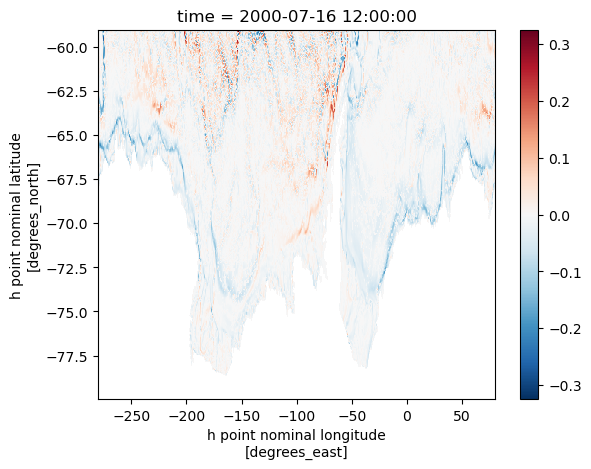

In [33]:
barotropic_alongslope_velocity_C.plot()

In [42]:
def shelf_mask_isobath(var, model_dict):

    paths = {"mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc", 
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [47]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)

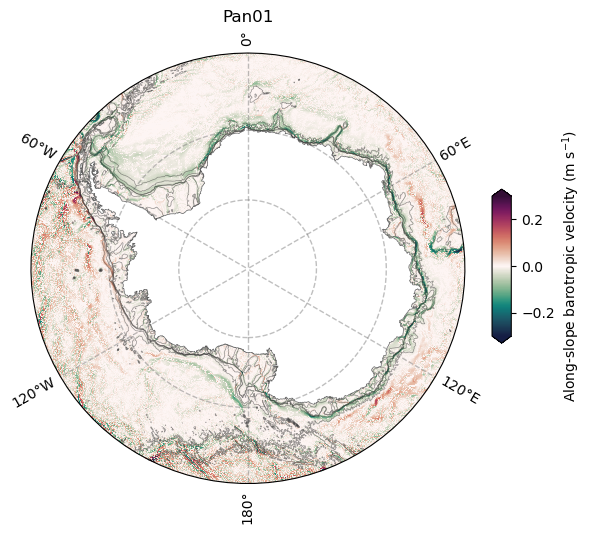

In [51]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())

# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.1,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Depth contours
depth.plot.contour(ax=ax, levels=[500, 1000, 2000, 3000],
                colors='0.2', linewidths=[0.5, 0.75, 0.5, 0.5], alpha=0.5,
                transform=ccrs.PlateCarree())

# Along slope barotropic velocity
sc = barotropic_alongslope_velocity_C.plot(ax=ax, cmap=cm.cm.curl,
                                         transform=ccrs.PlateCarree(),
                                         vmin=-0.3, vmax=0.3,
                                         cbar_kwargs={'orientation': 'vertical',
                                                      'shrink': 0.25,
                                                      'extend': 'both',
                                                      'label': 'Along-slope barotropic velocity (m s$^{-1}$)',
                                                      'aspect': 8})
  
ax.set_title('Pan01');

In [52]:
barotropic_alongslope_velocity_C.min()

<xarray.DataArray ()> Size: 8B
array(-0.32488045)
Coordinates:
    time     object 8B 2000-07-16 12:00:00